In [11]:
import sys

sys.path.append("..")

In [104]:
import random

import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib

from src.util import *
from src.model import *

tqdm.pandas()

In [13]:
last_review_date = pd.to_datetime("2015/01/01")
train_split_date = pd.to_datetime("2017/01/01")
test_split_date = pd.to_datetime("2018/01/01")

seed = 0
random.seed(seed)
np.random.seed(seed)

In [14]:
interaction_df, user_le, item_le = load_interaction_df(
    last_review_date=last_review_date,
    train_split_date=train_split_date,
)

(
    train_dataset,
    test_dataset,
    train_user_feature_table,
    test_user_feature_table,
) = create_dataset(
    interaction_df=interaction_df,
    train_split_date=train_split_date,
    test_split_date=test_split_date,
)

100%|██████████| 25093/25093 [00:00<00:00, 101555.62it/s]


In [35]:
device = "mps" if torch.backends.mps.is_available() else "cpu"

target_loss_weight = 1
clv_loss_weight = 1
alpha = target_loss_weight / (target_loss_weight + clv_loss_weight)

args = Args(
    d_model=32,
    batch_size=64,
    nhead=4,
    epochs=20,
    lr=1e-3,
    sample_size=5,
    alpha=alpha,
    device=device,
    model_path="model_churn.model",
)

try:
    model = torch.load(args.model_path)
    print(f"loaded model from: {args.model_path}")
except FileNotFoundError:
    model = Model(
        item_size=len(item_le.classes_),
        user_feature_dim=train_user_feature_table.shape[1],
        d_model=args.d_model,
        nhead=args.nhead,
    )
model.to(args.device)
model.train()

print(f"args: {args}")
train_results, test_results = train(
    model=model,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    train_user_feature_table=train_user_feature_table,
    test_user_feature_table=test_user_feature_table,
    args=args,
    items=item_le.classes_,
)

torch.save(model, args.model_path)
print(f"saved model to: {args.model_path}")

loaded model from: model_churn.model
args: Args(d_model=32, batch_size=64, nhead=4, epochs=20, lr=0.001, sample_size=5, alpha=0.5, context_item_size=9, device='mps', model_path='model_churn.model')
[epoch: 1/20]


100%|██████████| 393/393 [00:23<00:00, 16.61it/s]


[train][loss] target_loss: 0.081026, clv_loss: 0.315289
[train][alpha_weighted_loss] target_loss: 0.040513, clv_loss: 0.157645


100%|██████████| 393/393 [00:07<00:00, 53.17it/s]


[test][loss] target_loss: 0.099862, clv_loss: 0.318165
[test][alpha_weighted_loss] target_loss: 0.049931, clv_loss: 0.159083
[epoch: 2/20]


100%|██████████| 393/393 [00:22<00:00, 17.35it/s]


[train][loss] target_loss: 0.075786, clv_loss: 0.313020
[train][alpha_weighted_loss] target_loss: 0.037893, clv_loss: 0.156510


100%|██████████| 393/393 [00:07<00:00, 51.21it/s]


[test][loss] target_loss: 0.100682, clv_loss: 0.320790
[test][alpha_weighted_loss] target_loss: 0.050341, clv_loss: 0.160395
[epoch: 3/20]


100%|██████████| 393/393 [00:24<00:00, 16.25it/s]


[train][loss] target_loss: 0.071974, clv_loss: 0.309050
[train][alpha_weighted_loss] target_loss: 0.035987, clv_loss: 0.154525


100%|██████████| 393/393 [00:07<00:00, 52.21it/s]


[test][loss] target_loss: 0.104675, clv_loss: 0.324926
[test][alpha_weighted_loss] target_loss: 0.052338, clv_loss: 0.162463
[epoch: 4/20]


100%|██████████| 393/393 [00:22<00:00, 17.43it/s]


[train][loss] target_loss: 0.068587, clv_loss: 0.307334
[train][alpha_weighted_loss] target_loss: 0.034293, clv_loss: 0.153667


100%|██████████| 393/393 [00:07<00:00, 50.26it/s]


[test][loss] target_loss: 0.095551, clv_loss: 0.327345
[test][alpha_weighted_loss] target_loss: 0.047775, clv_loss: 0.163673
[epoch: 5/20]


100%|██████████| 393/393 [00:22<00:00, 17.17it/s]


[train][loss] target_loss: 0.066543, clv_loss: 0.307318
[train][alpha_weighted_loss] target_loss: 0.033272, clv_loss: 0.153659


100%|██████████| 393/393 [00:07<00:00, 52.35it/s]


[test][loss] target_loss: 0.107126, clv_loss: 0.325172
[test][alpha_weighted_loss] target_loss: 0.053563, clv_loss: 0.162586
[epoch: 6/20]


100%|██████████| 393/393 [00:23<00:00, 16.73it/s]


[train][loss] target_loss: 0.066610, clv_loss: 0.302954
[train][alpha_weighted_loss] target_loss: 0.033305, clv_loss: 0.151477


100%|██████████| 393/393 [00:07<00:00, 49.74it/s]


[test][loss] target_loss: 0.084445, clv_loss: 0.310177
[test][alpha_weighted_loss] target_loss: 0.042222, clv_loss: 0.155089
[epoch: 7/20]


100%|██████████| 393/393 [00:24<00:00, 16.18it/s]


[train][loss] target_loss: 0.062499, clv_loss: 0.302486
[train][alpha_weighted_loss] target_loss: 0.031250, clv_loss: 0.151243


100%|██████████| 393/393 [00:07<00:00, 49.77it/s]


[test][loss] target_loss: 0.089383, clv_loss: 0.317694
[test][alpha_weighted_loss] target_loss: 0.044691, clv_loss: 0.158847
[epoch: 8/20]


100%|██████████| 393/393 [00:22<00:00, 17.19it/s]


[train][loss] target_loss: 0.061636, clv_loss: 0.299685
[train][alpha_weighted_loss] target_loss: 0.030818, clv_loss: 0.149842


100%|██████████| 393/393 [00:07<00:00, 52.17it/s]


[test][loss] target_loss: 0.095944, clv_loss: 0.315656
[test][alpha_weighted_loss] target_loss: 0.047972, clv_loss: 0.157828
[epoch: 9/20]


100%|██████████| 393/393 [00:24<00:00, 16.12it/s]


[train][loss] target_loss: 0.058236, clv_loss: 0.297189
[train][alpha_weighted_loss] target_loss: 0.029118, clv_loss: 0.148594


100%|██████████| 393/393 [00:07<00:00, 51.55it/s]


[test][loss] target_loss: 0.092540, clv_loss: 0.317226
[test][alpha_weighted_loss] target_loss: 0.046270, clv_loss: 0.158613
[epoch: 10/20]


100%|██████████| 393/393 [00:22<00:00, 17.26it/s]


[train][loss] target_loss: 0.058819, clv_loss: 0.297858
[train][alpha_weighted_loss] target_loss: 0.029410, clv_loss: 0.148929


100%|██████████| 393/393 [00:07<00:00, 52.31it/s]


[test][loss] target_loss: 0.087761, clv_loss: 0.314004
[test][alpha_weighted_loss] target_loss: 0.043880, clv_loss: 0.157002
[epoch: 11/20]


100%|██████████| 393/393 [00:22<00:00, 17.34it/s]


[train][loss] target_loss: 0.058398, clv_loss: 0.297186
[train][alpha_weighted_loss] target_loss: 0.029199, clv_loss: 0.148593


100%|██████████| 393/393 [00:07<00:00, 51.70it/s]


[test][loss] target_loss: 0.086845, clv_loss: 0.310026
[test][alpha_weighted_loss] target_loss: 0.043422, clv_loss: 0.155013
[epoch: 12/20]


100%|██████████| 393/393 [00:23<00:00, 16.51it/s]


[train][loss] target_loss: 0.057107, clv_loss: 0.295759
[train][alpha_weighted_loss] target_loss: 0.028553, clv_loss: 0.147879


100%|██████████| 393/393 [00:07<00:00, 51.38it/s]


[test][loss] target_loss: 0.084308, clv_loss: 0.309041
[test][alpha_weighted_loss] target_loss: 0.042154, clv_loss: 0.154521
[epoch: 13/20]


100%|██████████| 393/393 [00:22<00:00, 17.18it/s]


[train][loss] target_loss: 0.055549, clv_loss: 0.294219
[train][alpha_weighted_loss] target_loss: 0.027775, clv_loss: 0.147110


100%|██████████| 393/393 [00:07<00:00, 51.57it/s]


[test][loss] target_loss: 0.082977, clv_loss: 0.305086
[test][alpha_weighted_loss] target_loss: 0.041488, clv_loss: 0.152543
[epoch: 14/20]


100%|██████████| 393/393 [00:22<00:00, 17.38it/s]


[train][loss] target_loss: 0.055413, clv_loss: 0.292990
[train][alpha_weighted_loss] target_loss: 0.027707, clv_loss: 0.146495


100%|██████████| 393/393 [00:07<00:00, 50.88it/s]


[test][loss] target_loss: 0.093863, clv_loss: 0.316078
[test][alpha_weighted_loss] target_loss: 0.046931, clv_loss: 0.158039
[epoch: 15/20]


100%|██████████| 393/393 [00:23<00:00, 17.04it/s]


[train][loss] target_loss: 0.053038, clv_loss: 0.292991
[train][alpha_weighted_loss] target_loss: 0.026519, clv_loss: 0.146496


100%|██████████| 393/393 [00:07<00:00, 50.21it/s]


[test][loss] target_loss: 0.093354, clv_loss: 0.321587
[test][alpha_weighted_loss] target_loss: 0.046677, clv_loss: 0.160794
[epoch: 16/20]


100%|██████████| 393/393 [00:22<00:00, 17.33it/s]


[train][loss] target_loss: 0.052346, clv_loss: 0.292723
[train][alpha_weighted_loss] target_loss: 0.026173, clv_loss: 0.146361


100%|██████████| 393/393 [00:08<00:00, 48.93it/s]


[test][loss] target_loss: 0.080849, clv_loss: 0.304490
[test][alpha_weighted_loss] target_loss: 0.040425, clv_loss: 0.152245
[epoch: 17/20]


100%|██████████| 393/393 [00:22<00:00, 17.29it/s]


[train][loss] target_loss: 0.052218, clv_loss: 0.289148
[train][alpha_weighted_loss] target_loss: 0.026109, clv_loss: 0.144574


100%|██████████| 393/393 [00:07<00:00, 52.04it/s]


[test][loss] target_loss: 0.086373, clv_loss: 0.318766
[test][alpha_weighted_loss] target_loss: 0.043186, clv_loss: 0.159383
[epoch: 18/20]


100%|██████████| 393/393 [00:22<00:00, 17.16it/s]


[train][loss] target_loss: 0.053413, clv_loss: 0.290825
[train][alpha_weighted_loss] target_loss: 0.026707, clv_loss: 0.145413


100%|██████████| 393/393 [00:07<00:00, 52.17it/s]


[test][loss] target_loss: 0.082449, clv_loss: 0.305406
[test][alpha_weighted_loss] target_loss: 0.041224, clv_loss: 0.152703
[epoch: 19/20]


100%|██████████| 393/393 [00:22<00:00, 17.29it/s]


[train][loss] target_loss: 0.052546, clv_loss: 0.289516
[train][alpha_weighted_loss] target_loss: 0.026273, clv_loss: 0.144758


100%|██████████| 393/393 [00:07<00:00, 52.42it/s]


[test][loss] target_loss: 0.089830, clv_loss: 0.316625
[test][alpha_weighted_loss] target_loss: 0.044915, clv_loss: 0.158313
[epoch: 20/20]


100%|██████████| 393/393 [00:23<00:00, 16.50it/s]


[train][loss] target_loss: 0.051001, clv_loss: 0.289944
[train][alpha_weighted_loss] target_loss: 0.025501, clv_loss: 0.144972


100%|██████████| 393/393 [00:07<00:00, 51.06it/s]


[test][loss] target_loss: 0.089711, clv_loss: 0.307798
[test][alpha_weighted_loss] target_loss: 0.044855, clv_loss: 0.153899
saved model to: model_churn.model


In [ ]:
model.eval()

filter_sample_size = 10
sample_size = 100

for (user_id, user_context_items), target_items, clv in test_dataset:
    if len(target_items) == 0:
        continue

    b = None
    for _ in range(filter_sample_size):
        user_ids = []
        item_indices = []

        context_items = []
        for _ in range(args.context_item_size):
            context_items.append(user_context_items[random.randrange(len(user_context_items))])

        for target in item_le.classes_:
            v = list(context_items)
            v.append(target)
            user_ids.append(user_id)
            item_indices.append(v)

        user_features = torch.FloatTensor(test_user_feature_table[user_ids]).to(args.device)
        item_indices = torch.LongTensor(item_indices).to(args.device)

        with torch.no_grad():
            y_clv, y_target = model.forward(user_features, item_indices)

        a = y_target.cpu().detach().numpy()
        if b is None:
            b = a
        else:
            b += a

    b /= filter_sample_size
    filtered_items = item_le.classes_[np.argsort(b)][::-1][:100] # 降順でソートし、上位100件を取得する
    print("before rerank:", len(set(filtered_items[:10]) & set(target_items)), "/", len(target_items))

    clv_sum = []
    for item in filtered_items:
        user_ids = []
        item_indices = []

        for _ in range(sample_size):
            context_items = []
            for _ in range(args.context_item_size):
                context_items.append(user_context_items[random.randrange(len(user_context_items))])

            v = list(context_items)
            v.append(item)
            user_ids.append(user_id)
            item_indices.append(v)

        user_features = torch.FloatTensor(test_user_feature_table[user_ids]).to(args.device)
        item_indices = torch.LongTensor(item_indices).to(args.device)

        with torch.no_grad():
            y_clv, y_target = model.forward(user_features, item_indices)

        clv_sum.append(y_clv.sum().item())

    recommendation = filtered_items[np.argsort(clv_sum)][::-1]
    print("after rerank:", len(set(recommendation[:10]) & set(target_items)), "/", len(target_items))

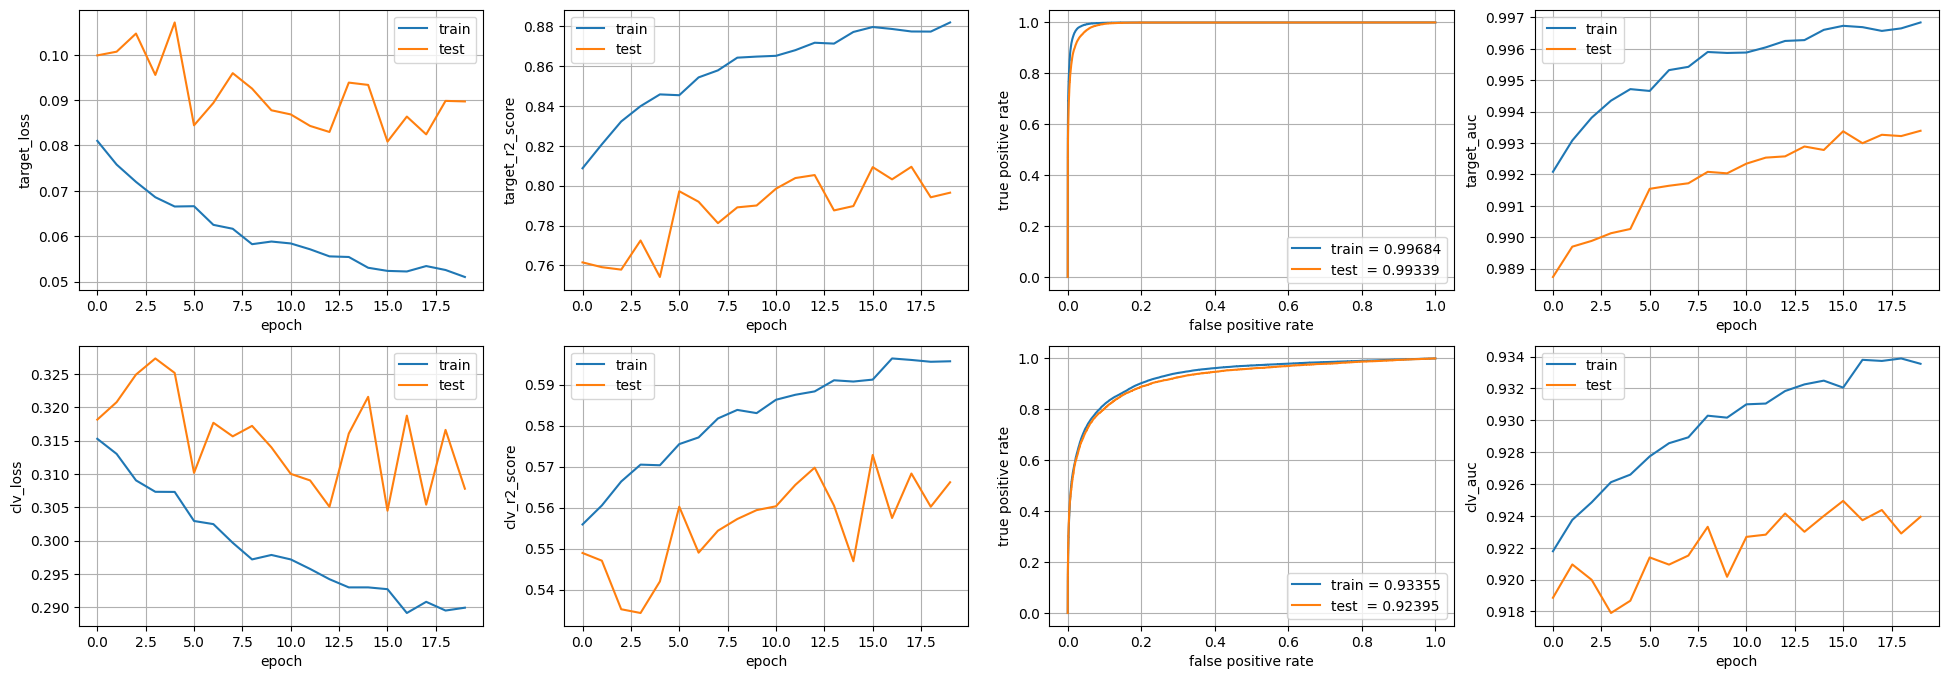

In [105]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(24, 8))
loss_names = ["target", "clv"]

for i, loss_name in enumerate(loss_names):
    plot_loss(train_results, test_results, loss_name, axes[i, 0])
    plot_r2_score(train_results, test_results, loss_name, axes[i, 1])
    plot_roc_auc(train_results[-1], test_results[-1], loss_name, axes[i, 2])
    plot_auc(train_results, test_results, loss_name, axes[i, 3])

plt.show()